In [1]:
__author__ = 'Yueling Xu <yuelingx@fnal.gov>' # single string; emails in <>
__version__ = '20210609' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['delve_dr1','gaia_edr3']  # datasets used in this notebook; for available datasets, see cell "Available datasets in Data Lab" further below
__keywords__ = [''], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/noaodatalab/notebooks-latest/blob/master/internal/keywords.txt

In [2]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import numpy as np
import pylab as plt
import matplotlib
import healpy as hp
import pandas as pd
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc

In [3]:
# getting necessary columns from DELVE within a certain RA and DEC (in this case, -20<dec<-10 and 120<ra<130)
sql =\
'''
SELECT mag_psf_g,spread_model_g,spreaderr_model_g,mag_auto_g,quick_object_id
FROM delve_dr1.objects
WHERE dec>-20 and dec<-10 and ra>120 and ra<130
'''
df = qc.query(sql=sql,fmt='pandas')

In [4]:
df

mag_psf_g  spread_model_g  spreaderr_model_g  mag_auto_g  \
0        99.000000       -1.000000           1.000000   99.000000   
1        99.000000       -1.000000           1.000000   99.000000   
2        99.000000       -1.000000           1.000000   99.000000   
3        99.000000       -1.000000           1.000000   99.000000   
4        99.000000       -1.000000           1.000000   99.000000   
...            ...             ...                ...         ...   
6114326  99.000000       -1.000000           1.000000   99.000000   
6114327  99.000000       -1.000000           1.000000   99.000000   
6114328  24.010647        0.011709           0.004868   23.715319   
6114329  22.267517       -0.000641           0.001128   22.308388   
6114330  23.197510       -0.001457           0.002457   23.185501   

         quick_object_id  
0         10830000222960  
1         10830000222954  
2         10830000223060  
3         10830000222937  
4         10830000222939  
...                  ...  
6114326   10830000223183  
6114327   10830000223189  
6114328   10830000299630  
6114329   10830000299600  
6114330   10830000122070  

[6114331 rows x 5 columns]

In [5]:
# getting indices for reasonable values of spread_model_g (following plot in fig 6 here: https://arxiv.org/pdf/2103.07476.pdf)
indices = (df['spread_model_g']<.045) & (df['spread_model_g']>-.025)

# converting to np arrays
mag_auto_g = np.array(df['mag_auto_g'][indices])
mag_psf_g = np.array(df['mag_psf_g'][indices])
spread_model_g = np.array(df['spread_model_g'][indices])
spreaderr_model_g = np.array(df['spreaderr_model_g'][indices])
quick_object_id = np.array(df['quick_object_id'][indices])

Text(0, 0.5, 'histogram')

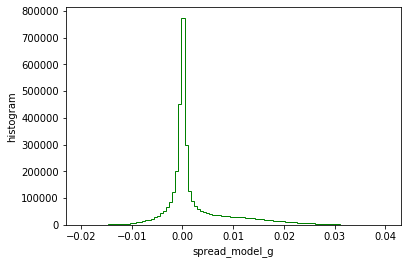

In [6]:
# plotting a histogram of the spread model values, just to see the distribution
fig, ax = plt.subplots(1,1)
ax.hist(spread_model_g,bins=100,range=(-.02,.04),histtype='step',lw=1,color='green')
ax.set_xlabel('spread_model_g')
ax.set_ylabel('histogram')

In [7]:
# this is an extremely inefficient method of calculating extended_class_g (described on page 16 of paper) but it works lmao
add3 = spread_model_g + 3*spreaderr_model_g
add = spread_model_g + spreaderr_model_g
diff = spread_model_g - spreaderr_model_g
val5 = np.full((len(add3)), 0.005)
val3 = np.full((len(add3)), 0.003)

true1 = np.greater(add3, val5)
true2 = np.greater(add, val3)
true3 = np.greater(diff, val3)

In [8]:
num1 = []
num2 = []
num3 = []

for item in true1:
    if item == True:
        num1.append(1)
    else:
        num1.append(0)
for item in true2:
    if item == True:
        num2.append(1)
    else:
        num2.append(0)
for item in true3:
    if item == True:
        num3.append(1)
    else:
        num3.append(0)

num1 = np.array(num1)
num2 = np.array(num2)
num3 = np.array(num3)

In [9]:
# value of extended_class_g
extended_class_g = num1 + num2 + num3

(-0.025, 0.045)

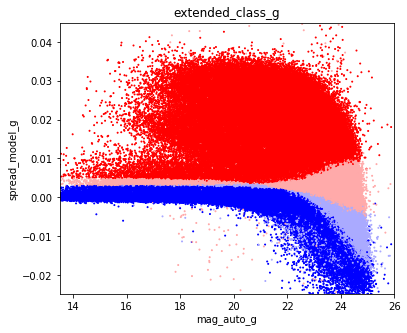

In [10]:
# recreation of fig. 6 from aforementioned patch of sky
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(mag_auto_g, spread_model_g, c=extended_class_g, cmap='bwr', vmin=0, vmax=3, s=1)
ax.set_xlabel('mag_auto_g')
ax.set_ylabel('spread_model_g')
ax.set_title('extended_class_g')
ax.set_xlim([13.5,26])
ax.set_ylim([-0.025,0.045])

# I tried to figure out how to get a colorbar on the plot and gave up

In [11]:
# getting all objects from patch of sky from -20<dec<-10 and 120<ra<130 from gaia x delve data
sql_x =\
'''
SELECT *
FROM gaia_edr3.x1p5__gaia_source__delve_dr1__objects
WHERE dec1>-20 and dec1<-10 and ra1>120 and ra1<130
'''
coords_x = qc.query(sql=sql_x,fmt='pandas')

In [12]:
coords_x

id1         ra1       dec1             id2  \
0        3038043849816265600  120.000001 -10.801280  10727500028295   
1        3036449519295960960  120.000003 -11.579927  10740200005175   
2        3036260953053072768  120.000017 -11.653540  10740200005170   
3        3038043815456539776  120.000030 -10.817037  10727500028298   
4        3038852398881686144  120.000061 -10.242220  10714600031521   
...                      ...         ...        ...             ...   
1941661  5708457873682071936  129.999976 -18.716264  10804600107704   
1941662  5747549188540562048  129.999986 -11.855139  10740600112794   
1941663  5710253921631073920  129.999990 -15.514968  10779000036546   
1941664  5708459522949506048  129.999998 -18.637549  10804600105365   
1941665  5708564972987159296  129.999999 -18.023832  10804600100307   

                ra2       dec2      distance  
0        119.999995 -10.801283  6.013239e-06  
1        120.000008 -11.579913  1.473089e-05  
2        120.000015 -11.653539  2.803247e-06  
3        120.000021 -10.817041  1.014988e-05  
4        120.000061 -10.242220  2.545069e-07  
...             ...        ...           ...  
1941661  129.999984 -18.716265  8.032601e-06  
1941662  129.999983 -11.855136  4.249568e-06  
1941663  129.999986 -15.514968  3.756337e-06  
1941664  129.999998 -18.637545  4.114637e-06  
1941665  129.999996 -18.023839  7.729674e-06  

[1941666 rows x 7 columns]

In [13]:
# turning the DELVE IDs into an array
ids = np.array(coords_x['id2'])

# basically seeing which ones match up
matches = np.in1d(quick_object_id, ids)

In [14]:
# getting the magnitudes/spreads of objects that are matched with gaia
gaia_mags = df['mag_auto_g'][indices][matches]
gaia_spreads = df['spread_model_g'][indices][matches]

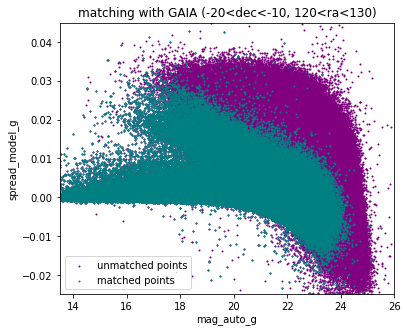

In [16]:
# plotting the matches with GAIA
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(mag_auto_g, spread_model_g, c='purple', s=1, label='unmatched points')
ax.scatter(gaia_mags, gaia_spreads, c='teal', s=1, label='matched points')
ax.set_xlabel('mag_auto_g')
ax.set_ylabel('spread_model_g')
ax.set_title('matching with GAIA (-20<dec<-10, 120<ra<130)')
ax.set_xlim([13.5,26])
ax.set_ylim([-0.025,0.045])
ax.legend(loc='best')